In [25]:
import pandas as pd

# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [26]:
df = pd.read_csv('1-data.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [27]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

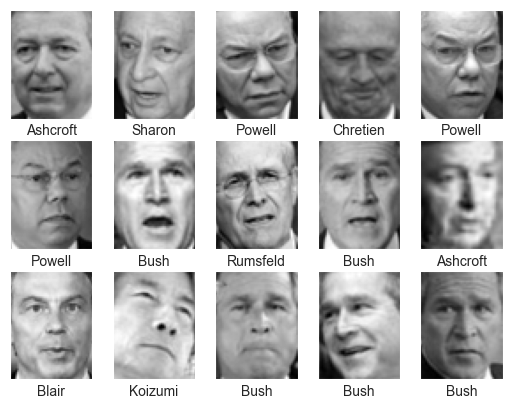

In [28]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
# plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

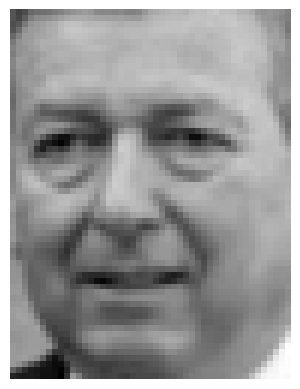

In [29]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [30]:
df['label'].nunique()

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [31]:
label_counts = df['label'].value_counts()
label_proportions = label_counts / len(df)
label_proportions

label
George W Bush        0.340121
Colin Powell         0.151584
Tony Blair           0.092006
Donald Rumsfeld      0.077677
Gerhard Schroeder    0.070136
Ariel Sharon         0.049020
Hugo Chavez          0.045249
Junichiro Koizumi    0.038462
Jean Chretien        0.035445
John Ashcroft        0.033937
Serena Williams      0.033183
Jacques Chirac       0.033183
Name: count, dtype: float64

In [32]:
name = 'Gerhard Schroeder'
round(label_proportions[name], 3)

0.07

Text(0.5, 1.0, 'Распределение объектов по классам')

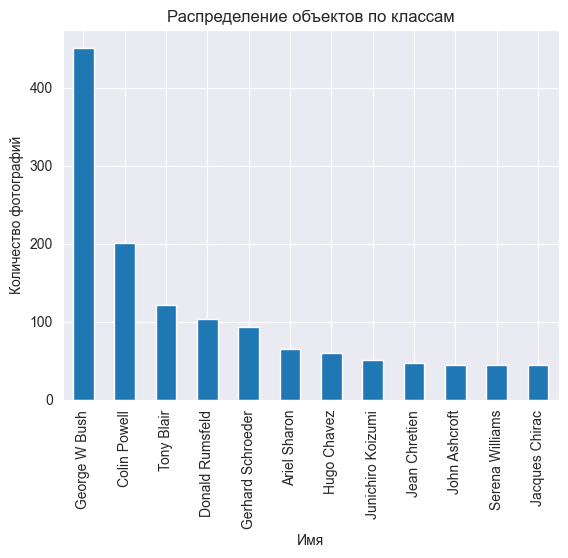

In [33]:
label_counts.plot(kind='bar')
plt.xlabel('Имя')
plt.ylabel('Количество фотографий')
plt.title('Распределение объектов по классам')

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [34]:
average_vectors = df.groupby('label').mean().reset_index()
average_vectors

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
1,Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
2,Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
3,George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
4,Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118
5,Hugo Chavez,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,...,0.337647,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052
6,Jacques Chirac,0.348010,0.368152,0.405704,0.436988,0.462686,0.498693,0.531135,0.553060,0.574629,...,0.453832,0.469935,0.480957,0.486067,0.510933,0.537998,0.542751,0.505853,0.456625,0.434997
7,Jean Chretien,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,...,0.526380,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608
8,John Ashcroft,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,...,0.472651,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495
9,Junichiro Koizumi,0.268384,0.253672,0.249699,0.257875,0.297373,0.352044,0.403306,0.441394,0.470819,...,0.505652,0.530437,0.561169,0.558657,0.542304,0.537896,0.532359,0.516750,0.498347,0.509753


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [35]:
person_vector = average_vectors[average_vectors['label'] == 'Gerhard Schroeder'].drop(columns=['label']).values
round(person_vector[0][0], 3)

0.21

Используя усредненные векторы, постройте изображения всех людей из набора данных.

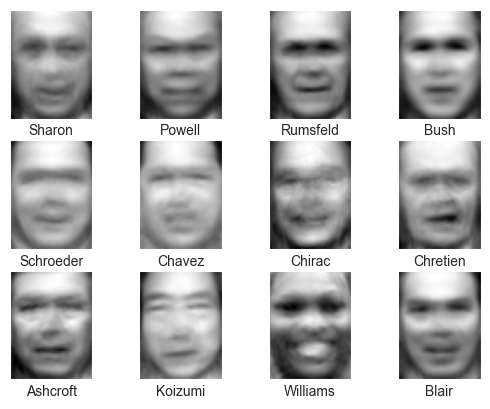

In [36]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(average_vectors.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [37]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [38]:
labels = average_vectors['label']
vectors = average_vectors.drop(columns=['label']).values

similarity_matrix = cosine_similarity(vectors)
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
similarity_df

label,Ariel Sharon,Colin Powell,Donald Rumsfeld,George W Bush,Gerhard Schroeder,Hugo Chavez,Jacques Chirac,Jean Chretien,John Ashcroft,Junichiro Koizumi,Serena Williams,Tony Blair
label,,,,,,,,,,,,
Ariel Sharon,1.000000,0.997854,0.996752,0.994814,0.993415,0.989612,0.993172,0.995977,0.995131,0.987816,0.987774,0.995362
Colin Powell,0.997854,1.000000,0.997700,0.996409,0.995470,0.992776,0.995131,0.996490,0.996295,0.990409,0.988370,0.997367
Donald Rumsfeld,0.996752,0.997700,1.000000,0.996645,0.996309,0.991954,0.995152,0.997448,0.995308,0.988584,0.986606,0.997292
George W Bush,0.994814,0.996409,0.996645,1.000000,0.997728,0.996353,0.996223,0.993516,0.997465,0.993667,0.985307,0.997331
Gerhard Schroeder,0.993415,0.995470,0.996309,0.997728,1.000000,0.997621,0.997229,0.994118,0.996986,0.993774,0.985748,0.998107
Hugo Chavez,0.989612,0.992776,0.991954,0.996353,0.997621,1.000000,0.995185,0.989890,0.994794,0.993828,0.983244,0.996131
Jacques Chirac,0.993172,0.995131,0.995152,0.996223,0.997229,0.995185,1.000000,0.993350,0.996172,0.994746,0.983479,0.996284
Jean Chretien,0.995977,0.996490,0.997448,0.993516,0.994118,0.989890,0.993350,1.000000,0.993907,0.986172,0.982785,0.995850
John Ashcroft,0.995131,0.996295,0.995308,0.997465,0.996986,0.994794,0.996172,0.993907,1.000000,0.993632,0.987354,0.996908


Text(0.5, 1.0, 'Матрица схожести')

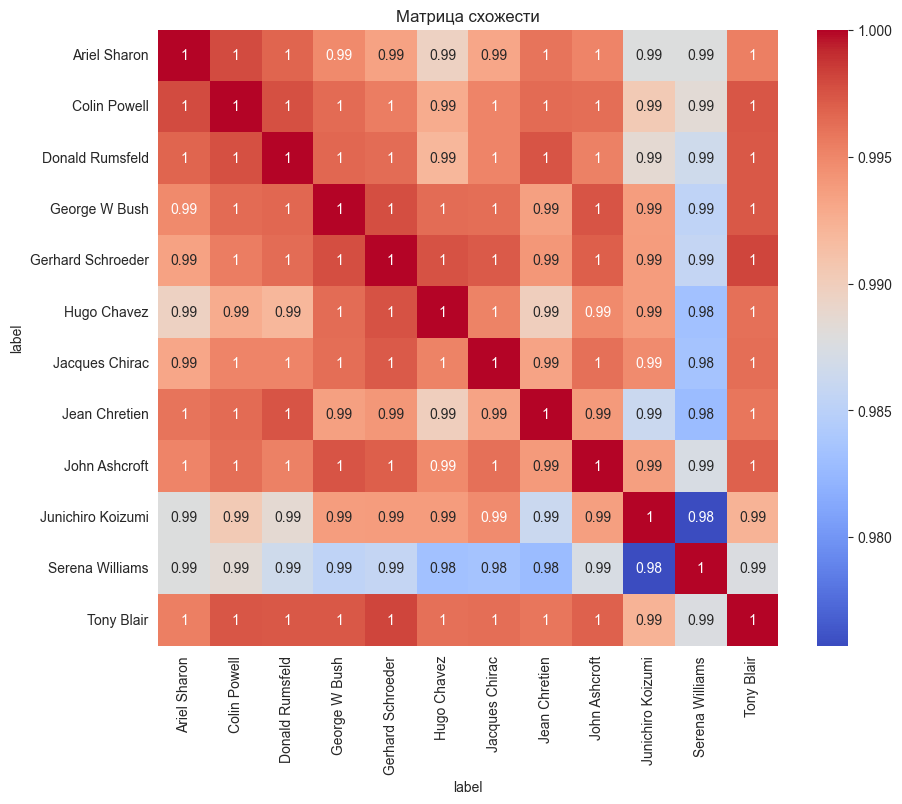

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Матрица схожести')

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [40]:
name1 = 'Gerhard Schroeder'
name2 = 'Hugo Chavez'

round(similarity_df.loc[name1, name2], 3)

0.998

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=7, stratify=df['label'])

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [43]:
from sklearn.svm import SVC

In [44]:
svc = SVC(kernel='linear', random_state=7).fit(X_train, y_train)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [45]:
from sklearn.metrics import f1_score

In [46]:
round(f1_score(y_test, svc.predict(X_test), average='weighted'), 3)

0.741

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[7]}]


grid_search = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.769 total time=   1.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.769 total time=   1.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.788 total time=   1.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.797 total time=   1.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.797 total time=   1.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.349 total time=   1.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.358 total time=   1.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.363 total time=   1.3s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [7]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [49]:
grid_search.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 7}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [50]:
round(f1_score(y_test, grid_search.best_estimator_.predict(X_test), average='weighted'), 3)

0.767

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca = PCA(svd_solver='full')
pca.fit(X_train)

PCA(svd_solver='full')

In [53]:
n_components = (pca.explained_variance_ratio_.cumsum() > 0.95).argmax() + 1
n_components

172

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [54]:
new_pca = PCA(n_components=n_components, svd_solver='full')
X_train = new_pca.fit_transform(X_train)
X_test = new_pca.transform(X_test)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [55]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.774 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.759 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.745 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.797 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=7;, score=0.764 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.344 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=7;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [7]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [56]:
grid_search.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 7}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [57]:
round(f1_score(y_test, grid_search.best_estimator_.predict(X_test), average='weighted'), 3)

0.769

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.